In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np

In [2]:
pd.set_option("display.max_columns", None)  # no column truncation
pd.set_option("display.max_rows", None)     # no row truncation
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)

In [3]:
path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention")
print("Path to dataset files:", path)
# List all files downloaded
print(os.listdir(path))

Path to dataset files: /Users/innerpiece92/.cache/kagglehub/datasets/thedevastator/higher-education-predictors-of-student-retention/versions/2
['dataset.csv']


In [4]:
df = pd.read_csv(os.path.join(path, "dataset.csv"))
print(df.head(7))

   Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   
5               2                12                  1      17   
6               1                 1                  1      12   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   
5                           0                      

### Exploratory Data Analysis

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [7]:
print(df.describe())

       Marital status  Application mode  Application order       Course  \
count     4424.000000       4424.000000        4424.000000  4424.000000   
mean         1.178571          6.886980           1.727848     9.899186   
std          0.605747          5.298964           1.313793     4.331792   
min          1.000000          1.000000           0.000000     1.000000   
25%          1.000000          1.000000           1.000000     6.000000   
50%          1.000000          8.000000           1.000000    10.000000   
75%          1.000000         12.000000           2.000000    13.000000   
max          6.000000         18.000000           9.000000    17.000000   

       Daytime/evening attendance  Previous qualification  Nacionality  \
count                 4424.000000             4424.000000  4424.000000   
mean                     0.890823                2.531420     1.254521   
std                      0.311897                3.963707     1.748447   
min                      0.0

In [8]:
df['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [9]:
print(df["Target"].value_counts())

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64


<Axes: >

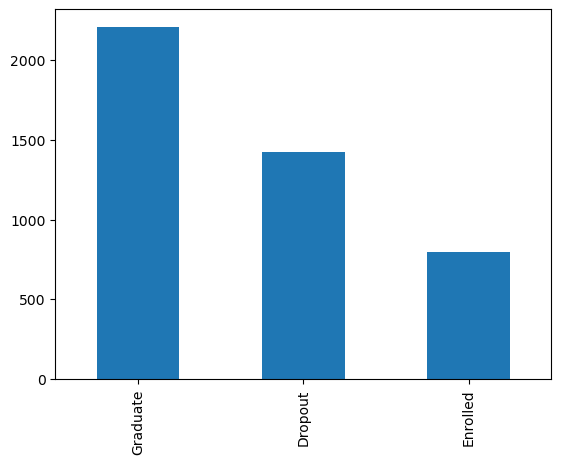

In [10]:
df['Target'].value_counts().plot(kind='bar')

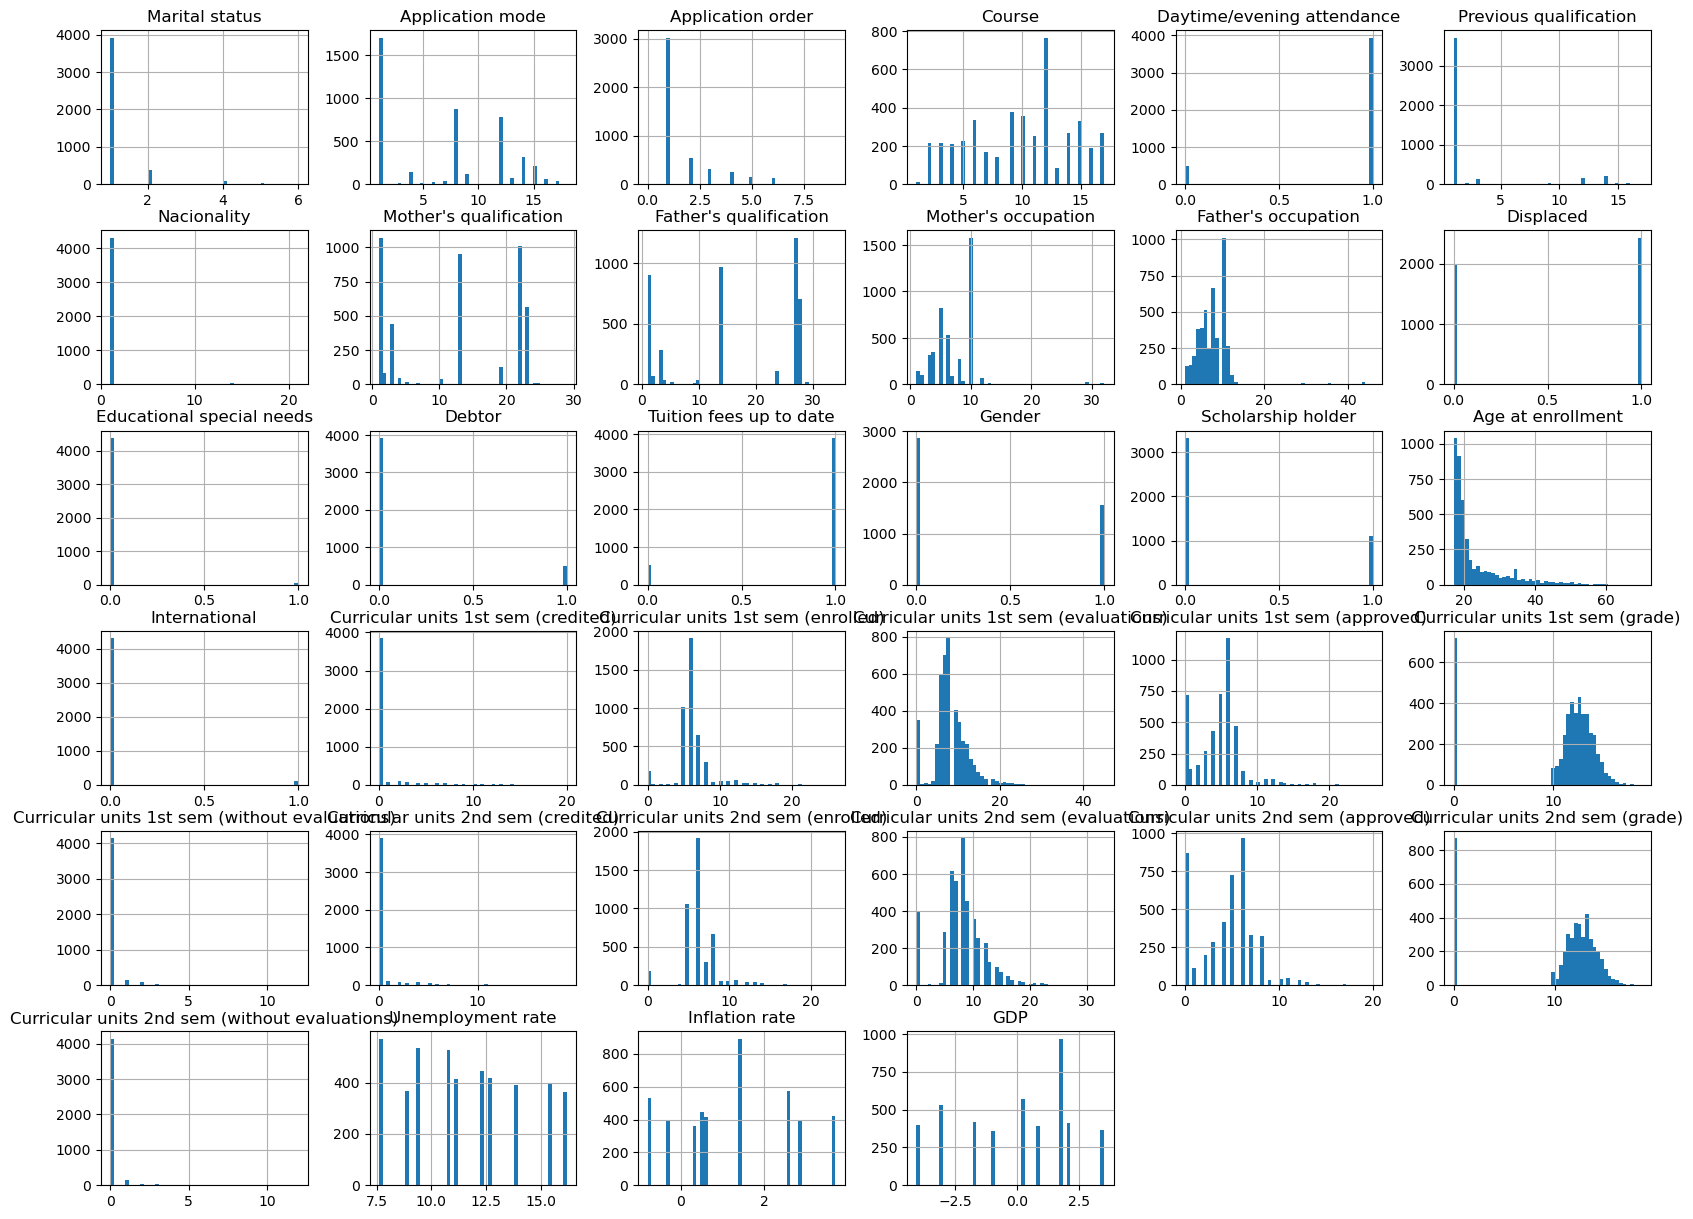

In [11]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### Data Transformations

In [12]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
# Make all transformers return pandas DataFrames by default
set_config(transform_output="pandas")

In [15]:
categorical_features = [
    "Application mode",
    "Marital status",
    "Course",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]
skewed_numerical_features = [
    "Age at enrollment",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)"
]
# Build a per-categorical pipeline (reused for each categorical column). With pipeline I can reuse the approach for
# other features
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(
        handle_unknown="infrequent_if_exist",
        min_frequency=30,
        sparse_output=False
    ))
])
num_log_pipe = Pipeline(steps=[
    ("log1p", FunctionTransformer(np.log1p, validate=False))
])
preprocessor = ColumnTransformer(transformers=[
    ("cat", cat_pipe, categorical_features), # select as a list to keep it 2D
    ("num_log", num_log_pipe, skewed_numerical_features),
    ],
    remainder = "passthrough", # "drop" or "passthrough" if you want other columns kept
    verbose_feature_names_out=False
)
# Fit + transform -> returns a pandas DataFrame because of set_config above
enc_df = preprocessor.fit_transform(df)

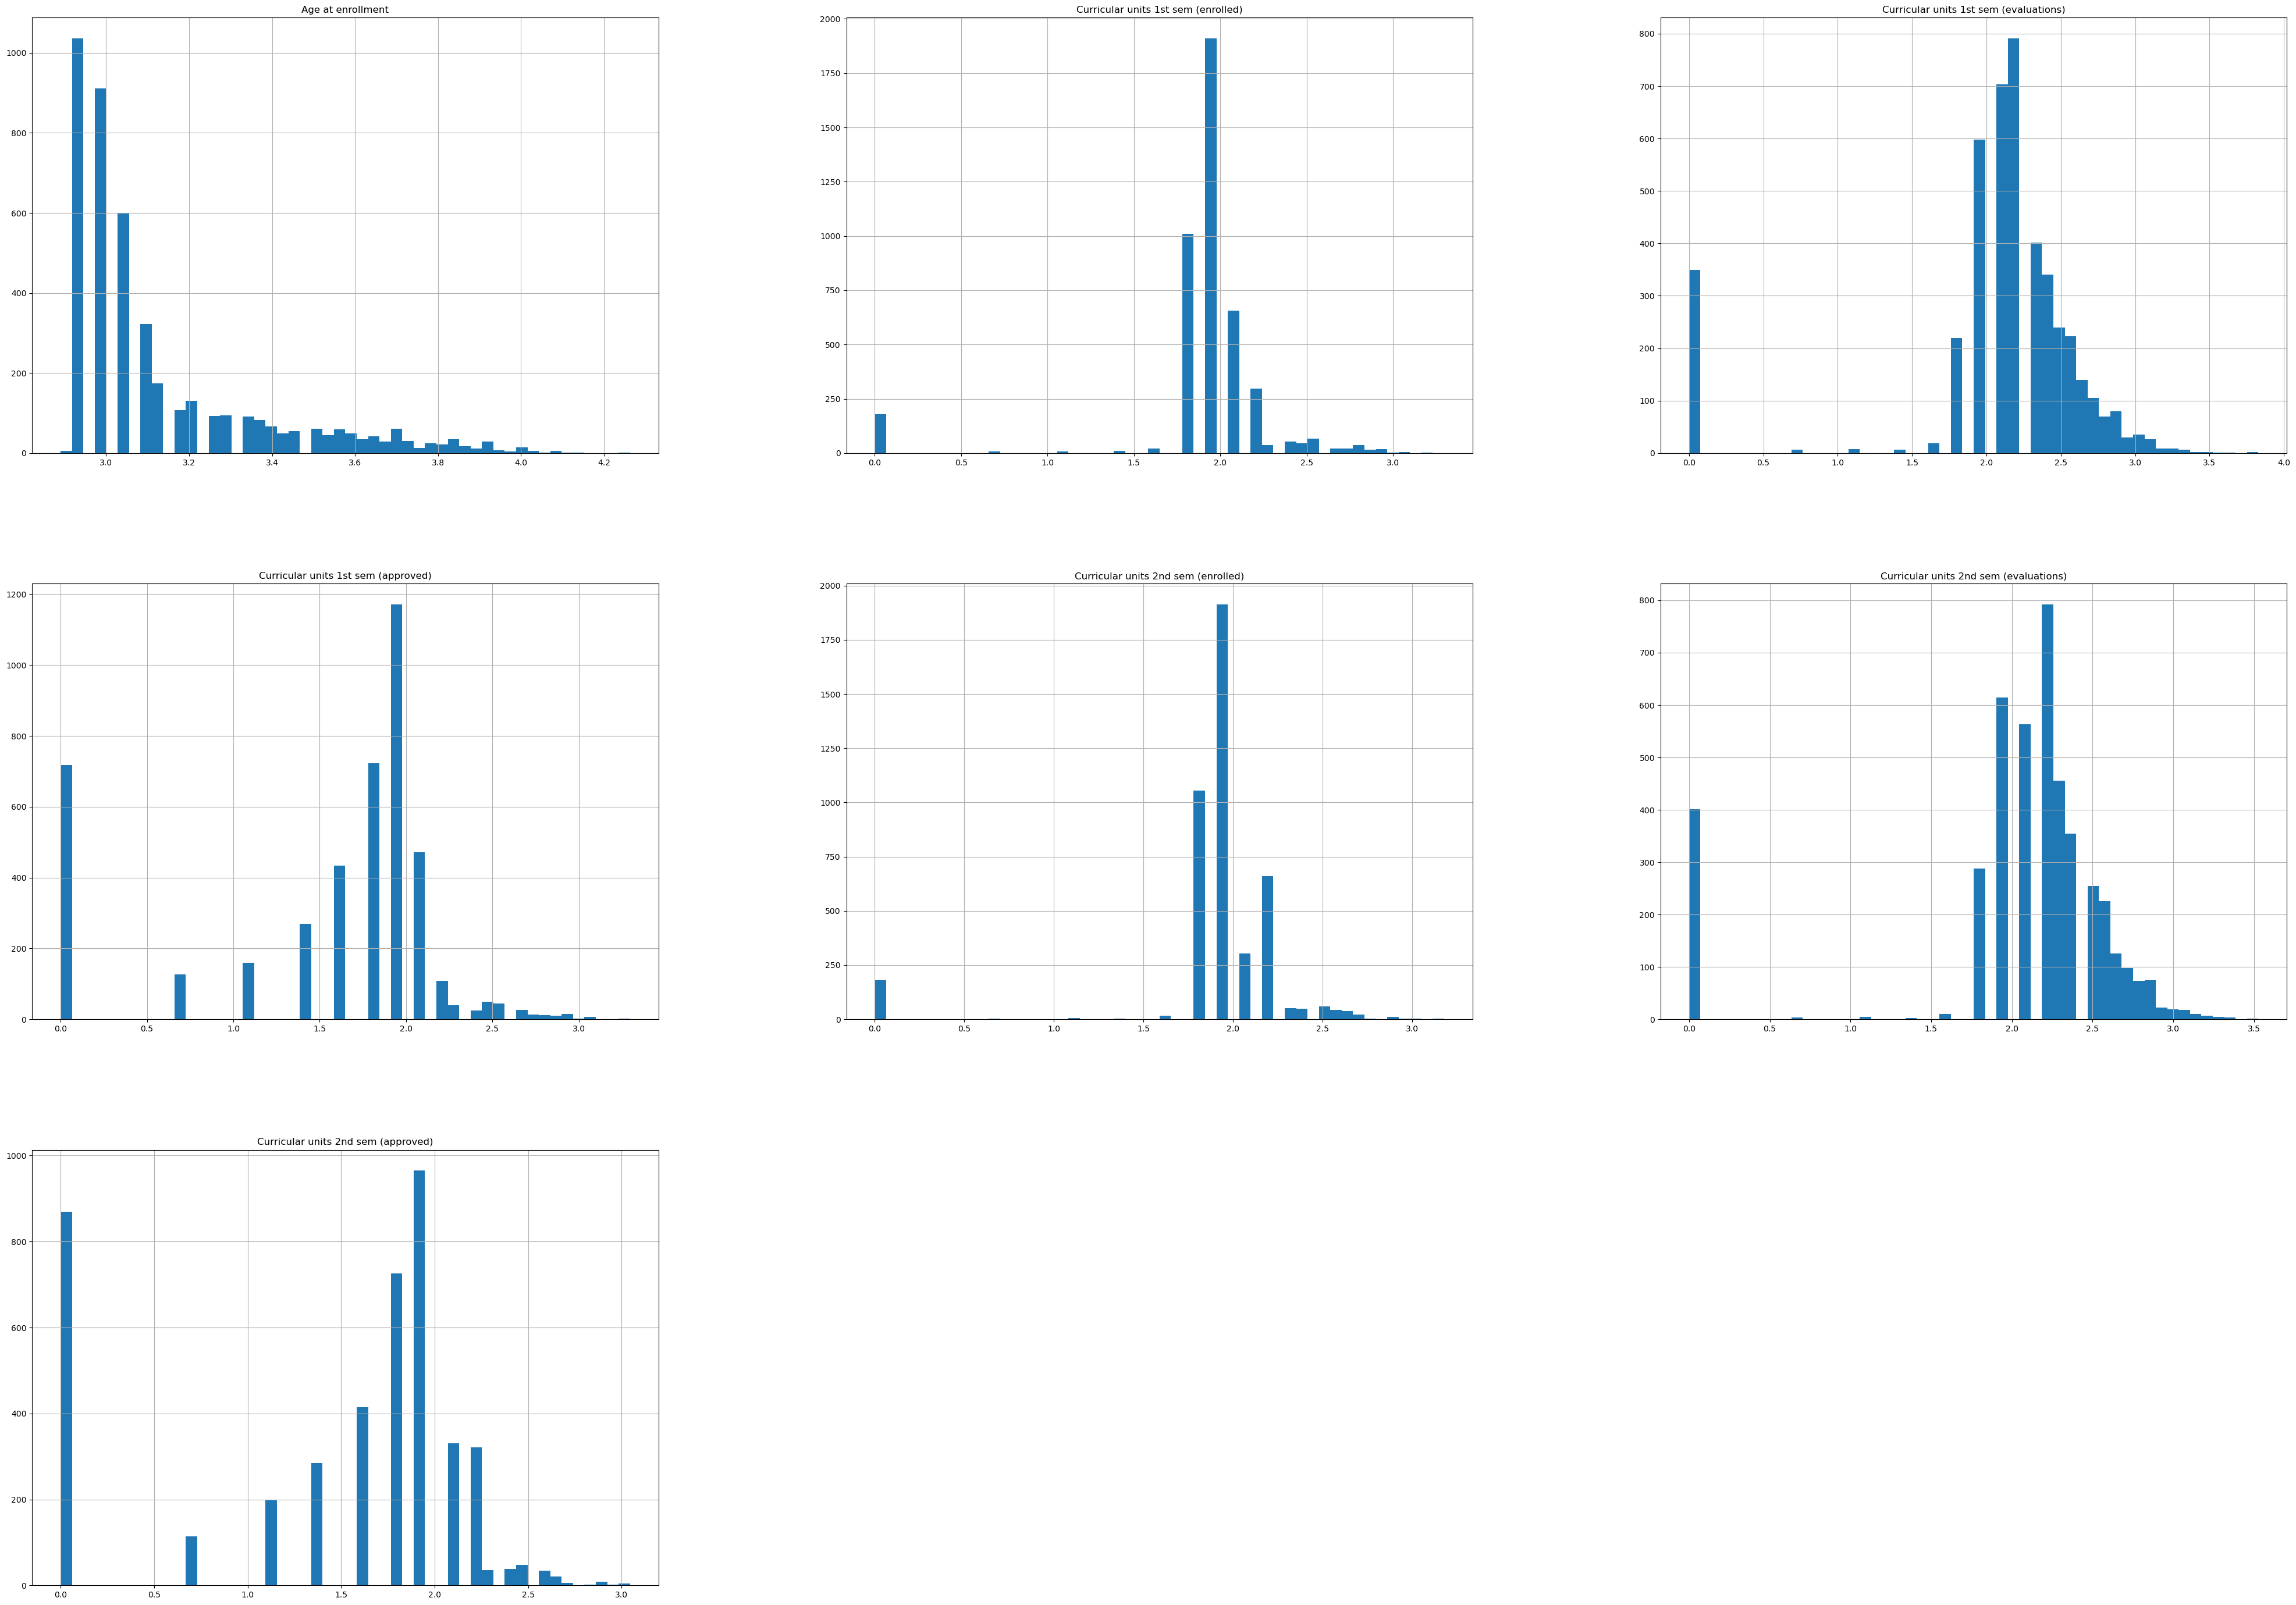

In [16]:
enc_df[["Age at enrollment",
"Curricular units 1st sem (enrolled)",
"Curricular units 1st sem (evaluations)",
"Curricular units 1st sem (approved)",
"Curricular units 2nd sem (enrolled)",
"Curricular units 2nd sem (evaluations)",
"Curricular units 2nd sem (approved)"]].hist(bins=50, figsize=(50,35))
plt.show()

In [17]:
le = LabelEncoder()
enc_df['Target_enc'] = le.fit_transform(df['Target'])
enc_df = enc_df.drop('Target', axis=1)
print(enc_df.dtypes)

Application mode_1                                float64
Application mode_4                                float64
Application mode_6                                float64
Application mode_7                                float64
Application mode_8                                float64
Application mode_9                                float64
Application mode_12                               float64
Application mode_13                               float64
Application mode_14                               float64
Application mode_15                               float64
Application mode_16                               float64
Application mode_17                               float64
Application mode_infrequent_sklearn               float64
Marital status_1                                  float64
Marital status_2                                  float64
Marital status_4                                  float64
Marital status_infrequent_sklearn                 float64
Course_2      

In [18]:
print(enc_df["Target_enc"].value_counts())

2    2209
0    1421
1     794
Name: Target_enc, dtype: int64


### Manual Feature Selection

#### Pearson Correlation

In [19]:
corr_target = enc_df.corr()["Target_enc"].drop("Target_enc").sort_values(ascending=False)
print(corr_target)

Curricular units 2nd sem (approved)               0.646877
Curricular units 2nd sem (grade)                  0.566827
Curricular units 1st sem (approved)               0.565891
Curricular units 1st sem (grade)                  0.485207
Tuition fees up to date                           0.409827
Scholarship holder                                0.297595
Application mode_1                                0.216306
Curricular units 2nd sem (evaluations)            0.206266
Course_12                                         0.197460
Curricular units 1st sem (evaluations)            0.154656
Previous qualification_1                          0.139559
Curricular units 2nd sem (enrolled)               0.135606
Curricular units 1st sem (enrolled)               0.130581
Displaced                                         0.113986
Course_10                                         0.112201
Marital status_1                                  0.106408
Application order                                 0.0897

In [20]:
corr_viz = enc_df.corr(numeric_only=True)
plt.figure(figsize=(len(enc_df.corr().columns)*1, len(enc_df.corr().columns)*1))
sns.heatmap(corr_viz, annot = True, cmap="coolwarm")
plt.title("Correlation Heatmap of features", fontsize=16)
plt.savefig("/Users/innerpiece92/Desktop/Project_Workspace/students_success_dropout/heatmap.png")
plt.show()

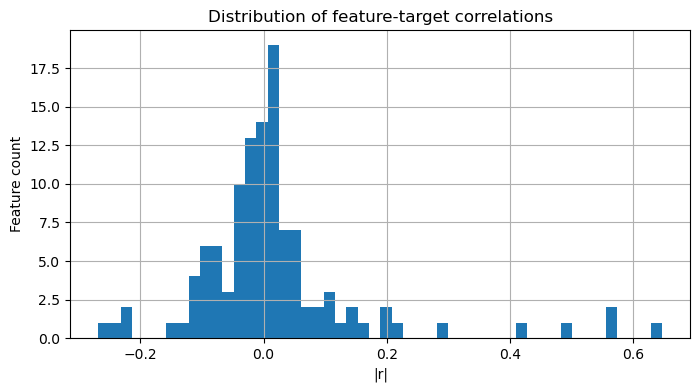

In [21]:
#### Histogram of correlation coefficients to see the overall picture
corr_target.hist(bins=50, figsize=(8,4))
plt.title("Distribution of feature-target correlations")
plt.xlabel("|r|")
plt.ylabel("Feature count")
plt.show()

#### Mutual Information

Only to get a sense of non-linear relationships. If huge list of features, calculate mutual information on a short list of selected features

In [22]:
from sklearn.feature_selection import mutual_info_classif

In [23]:
X = enc_df.drop(columns=["Target_enc"])
y = enc_df["Target_enc"]
mi = mutual_info_classif(X, y, discrete_features="auto", random_state=42)
## discrete_features="auto" treats integer-typed columns as discrete and float as continuous.
mi_series = pd.Series(mi, index=X.columns)
print(mi_series)

Application mode_1                                0.039224
Application mode_4                                0.019105
Application mode_6                                0.009925
Application mode_7                                0.000000
Application mode_8                                0.003949
Application mode_9                                0.000000
Application mode_12                               0.026678
Application mode_13                               0.007748
Application mode_14                               0.000000
Application mode_15                               0.000000
Application mode_16                               0.000317
Application mode_17                               0.002472
Application mode_infrequent_sklearn               0.000000
Marital status_1                                  0.001393
Marital status_2                                  0.014205
Marital status_4                                  0.009336
Marital status_infrequent_sklearn                 0.0000

Features to Keep:

    'Application mode'
    'Course'
    'Nacionality'
    'Displaced'
    'Tuition fees up to date'
    'Scholarship holder'
    'Age at enrollment'
    'Curricular units 1st sem (enrolled)'
    'Curricular units 1st sem (evaluations)'
    'Curricular units 1st sem (approved)'
    'Curricular units 1st sem (grade)'
    'Curricular units 2nd sem (enrolled)'
    'Curricular units 2nd sem (evaluations)'
    'Curricular units 2nd sem (approved)'
    'Curricular units 2nd sem (grade)'

### Model Training

In [25]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.utils.multiclass import unique_labels
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)

In [26]:
selected_features = ['Application mode_1',
'Application mode_4',
'Application mode_6',
'Application mode_7',
'Application mode_8',
'Application mode_9',
'Application mode_12',
'Application mode_13',
'Application mode_14',
'Application mode_15',
'Application mode_16',
'Application mode_17',
'Application mode_infrequent_sklearn',
'Course_2',
'Course_3',
'Course_4',
'Course_5',
'Course_6',
'Course_7',
'Course_8',
'Course_9',
'Course_10',
'Course_11',
'Course_12',
'Course_13',
'Course_14',
'Course_15',
'Course_16',
'Course_17',
'Course_infrequent_sklearn',
'Nacionality_1',
'Nacionality_14',
'Nacionality_infrequent_sklearn',
'Displaced',
'Tuition fees up to date',
'Scholarship holder',
'Age at enrollment',
'Curricular units 1st sem (enrolled)',
'Curricular units 1st sem (evaluations)',
'Curricular units 1st sem (approved)',
'Curricular units 1st sem (grade)',
'Curricular units 2nd sem (enrolled)',
'Curricular units 2nd sem (evaluations)',
'Curricular units 2nd sem (approved)',
'Curricular units 2nd sem (grade)'
]

In [29]:
results = [] 

In [30]:
RANDOM_STATE = 35

In [43]:
def evaluate_with_features(name, feature_list):
    """
    Refit an L1 multinomial LogisticRegressionCV on the given features, report TEST metrics,
    then freeze C and:
      - run cross_validate with return_train_score=True to get train vs validation scores
      - compute & optionally plot a learning curve (train vs CV across sample sizes)

    Returns a dict with fitted CV model, fixed-C pipeline, CV summary, and learning-curve arrays.
    """
    
    if len(feature_list) == 0:
        print(f"[{name}] skipped (no features).")
        return None
    
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, 
                                                    random_state=RANDOM_STATE ) 

    X_train_sel = X_train[feature_list]
    X_test_sel  = X_test[feature_list]
    
    return {
        "X_train": X_train_sel,
        "y_train": y_train,
        "X_test":  X_test_sel,
        "y_test":  y_test,
        "feature_list": feature_list,   # handy for logging
        "name": name
    }

In [56]:
def show_confusion_matrix(y_true, y_pred, class_names, title):
    labels = unique_labels(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, 
                         index=[f"true_{l}" for l in labels],
                         columns=[f"pred_{l}" for l in labels])
    
    print(f"\n{title} (rows = true, cols = pred)")
    #print(cm_df)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    return cm_df

In [57]:
def run_logistic_regression(X_train, y_train, X_test, y_test, feature_list, name, *, use_balanced=False, 
                            plot_learning=True, learning_sizes=None):
    
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")
    
    inner_cv = RepeatedStratifiedKFold( n_splits=5, # 5-fold 
                                   n_repeats=10, # 10 repeats => 50 fits per C 
                                   random_state=RANDOM_STATE ) 

    # A sensible C grid on standardized features
    C_grid = np.logspace(-4, 4, 21) # 1e-4 ... 1e4 

    # ----- 1) Fit LogisticRegressionCV -----
    '''
    This is the “hyperparameter tuner.”
    - What it does:
        - Runs cross-validation inside itself for a grid of C values.
        - Chooses the C that gives the best validation score (macro-F1 in your case).
        - Refits the model on the full training set at that C.
    - Output: a fitted model, plus knowledge of the best C.
    '''
    logit_cv = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=C_grid,
            cv=inner_cv,                  # RepeatedStratifiedKFold
            penalty="l1",
            solver="saga",
            multi_class="multinomial",
            scoring="f1_macro",
            max_iter=2000,
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            refit=True,
            class_weight=("balanced" if use_balanced else None)
        ))
    ])

    logit_cv.fit(X_train, y_train)

    # Best C(s): for multinomial, C_ can be per-class; show mean and unique values
    Cs_found = np.atleast_1d(logit_cv.named_steps["clf"].C_)
    C_mean   = float(np.mean(Cs_found))
    C_unique = np.unique(Cs_found).tolist()

    print(f"\n[{name}] LogisticRegressionCV fitted")
    print(f"  use_balanced={use_balanced}")
    print(f"  best C (mean over classes): {C_mean:.6g}")
    print(f"  best C values (unique): {C_unique}")

    # ----- 2) TEST metrics (frozen test set) -----
    y_pred_test = logit_cv.predict(X_test)
    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred_test),
        "test_f1_macro": f1_score(y_test, y_pred_test, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred_test, average="weighted"),
    }
    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")
            
    class_labels = logit_cv.named_steps["clf"].classes_ ## We can inverse transform with the label encoder
    logit_cm = show_confusion_matrix(y_test, y_pred_test, class_labels, 
                                     title="LogisticRegressionCV — Confusion matrix")

    # ----- 3) Freeze C and compute train vs validation scores with cross_validate -----
    '''
    - Once you know the best C, you can freeze it and re-wrap the model.
    - Why? Because you now want to study generalization behavior (train vs val, learning curve).
    - LogisticRegressionCV doesn’t expose per-fold train scores or an easy way to run learning_curve.
    - So you build a plain LogisticRegression with that chosen C, then plug it into cross_validate or learning_curve.
    '''
    logit_fixed = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l1",
            solver="saga",
            multi_class="multinomial",
            C=C_mean,                                  # freeze at CV-chosen C
            class_weight=("balanced" if use_balanced else None),
            max_iter=2000,
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
        ))
    ])

    cv_res = cross_validate(
        logit_fixed,
        X_train, y_train,
        cv=inner_cv,
        scoring={"f1_macro": "f1_macro", "neg_log_loss": "neg_log_loss"},
        return_train_score=True,
        n_jobs=-1
    )

    cv_summary = pd.DataFrame({
        "train_f1_macro":   cv_res["train_f1_macro"],
        "val_f1_macro":     cv_res["test_f1_macro"],
        "train_neg_logloss":cv_res["train_neg_log_loss"],
        "val_neg_logloss":  cv_res["test_neg_log_loss"],
    })
    print("\n[Cross-validate] train vs. validation (per fold) summary:")
    print(cv_summary.describe().round(4))

    # Quick gap indicators
    f1_gap = cv_summary["train_f1_macro"].mean() - cv_summary["val_f1_macro"].mean()
    ll_gap = (-cv_summary["train_neg_logloss"].mean()) - (-cv_summary["val_neg_logloss"].mean())
    
    # (neg_log_loss → invert sign to compare actual loss)
    print(f"\nAvg F1 gap (train - val): {f1_gap:.4f}  |  Avg log-loss gap (train - val): {ll_gap:.4f}")

    # ----- 4) Learning curve (train vs CV across sample sizes) -----
    if learning_sizes is None:
        learning_sizes = np.linspace(0.1, 1.0, 6)

    train_sizes, train_scores, val_scores = learning_curve(
        logit_fixed,
        X_train, y_train,
        cv=inner_cv,
        scoring="f1_macro",
        train_sizes=learning_sizes,
        n_jobs=N_JOBS,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    train_means = train_scores.mean(axis=1)
    train_stds  = train_scores.std(axis=1)
    val_means   = val_scores.mean(axis=1)
    val_stds    = val_scores.std(axis=1)

    if plot_learning:
        plt.figure(figsize=(7.2, 5.0))
        plt.title(f"Learning Curve — {name} (L1 multinomial LR)")
        plt.xlabel("Training examples")
        plt.ylabel("F1 (macro)")
        
        # Train curve
        plt.plot(train_sizes, train_means, marker="o", label="Train")
        plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds, alpha=0.2)
        
        # CV curve
        plt.plot(train_sizes, val_means, marker="s", label="CV")
        plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds, alpha=0.2)
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "name": name,
        "features": feature_list,
        "cv_model": logit_cv,
        "fixed_model": logit_fixed,
        "test_metrics": test_metrics,
        "cv_summary": cv_summary,                # per-fold train/val F1 & log-loss
        "learning_curve": {
            "train_sizes": train_sizes,
            "train_means": train_means,
            "train_stds":  train_stds,
            "val_means":   val_means,
            "val_stds":    val_stds,
        },
        "best_C_mean": C_mean,
        "best_C_values": C_unique,
        "use_balanced": use_balanced,
    }

[Job check] Detected CPU cores: 8. Using n_jobs=8.

[Hand Selected Features] LogisticRegressionCV fitted
  use_balanced=False
  best C (mean over classes): 15.8489
  best C values (unique): [15.848931924611142]

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7706
  test_f1_macro: 0.6859
  test_f1_weighted: 0.7538

LogisticRegressionCV — Confusion matrix (rows = true, cols = pred)


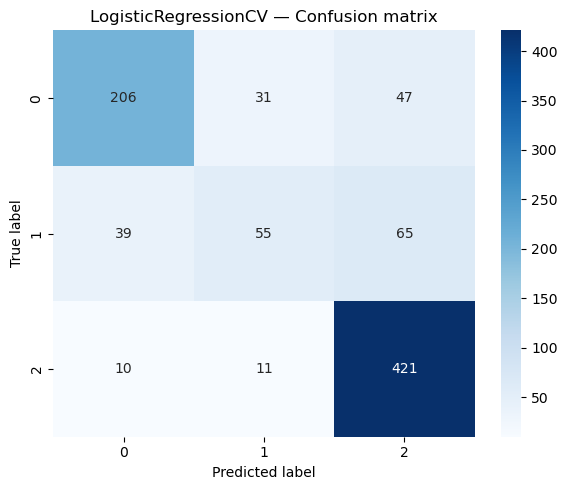


[Cross-validate] train vs. validation (per fold) summary:
       train_f1_macro  val_f1_macro  train_neg_logloss  val_neg_logloss
count         50.0000       50.0000            50.0000          50.0000
mean           0.7077        0.6872            -0.5378          -0.5728
std            0.0051        0.0146             0.0055           0.0241
min            0.6965        0.6594            -0.5497          -0.6229
25%            0.7039        0.6775            -0.5420          -0.5908
50%            0.7078        0.6859            -0.5376          -0.5744
75%            0.7114        0.6936            -0.5342          -0.5543
max            0.7171        0.7212            -0.5247          -0.5226

Avg F1 gap (train - val): 0.0205  |  Avg log-loss gap (train - val): -0.0351


/Users/innerpiece92/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/innerpiece92/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/innerpiece92/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/innerpiece92/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/innerpiece92/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/innerpiece92/anaconda3/

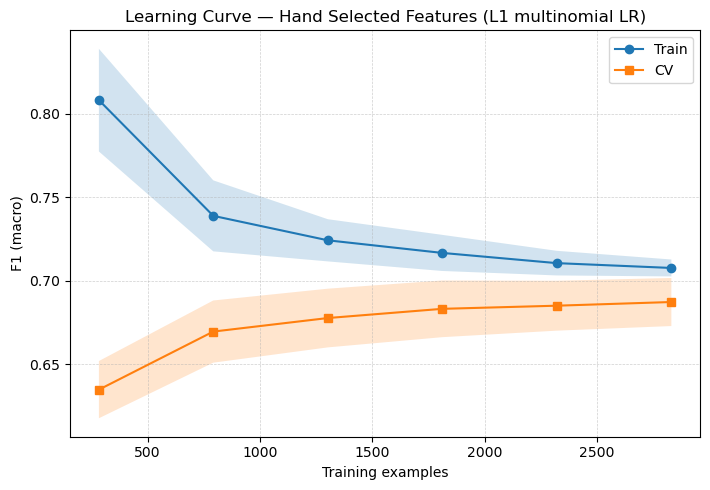

[{'name': 'Hand Selected Features', 'features': ['Application mode_1', 'Application mode_4', 'Application mode_6', 'Application mode_7', 'Application mode_8', 'Application mode_9', 'Application mode_12', 'Application mode_13', 'Application mode_14', 'Application mode_15', 'Application mode_16', 'Application mode_17', 'Application mode_infrequent_sklearn', 'Course_2', 'Course_3', 'Course_4', 'Course_5', 'Course_6', 'Course_7', 'Course_8', 'Course_9', 'Course_10', 'Course_11', 'Course_12', 'Course_13', 'Course_14', 'Course_15', 'Course_16', 'Course_17', 'Course_infrequent_sklearn', 'Nacionality_1', 'Nacionality_14', 'Nacionality_infrequent_sklearn', 'Displaced', 'Tuition fees up to date', 'Scholarship holder', 'Age at enrollment', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd se

In [58]:
results.append(run_logistic_regression(**evaluate_with_features("Hand Selected Features", selected_features)))
#print(results)

In [62]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [71]:
def run_random_forest(X_train, y_train, X_test, y_test, feature_list, name):
    
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")

    rf = RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",       # common setting for classification
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE
    )
    rf.fit(X_train, y_train)
    
    print(f"\n[{name}] RandomForest fitted")
    
    y_pred_rf = rf.predict(X_test)
    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred_rf),
        "test_f1_macro": f1_score(y_test, y_pred_rf, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred_rf, average="weighted"),
    }
    
    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")
    
    class_labels = rf.classes_ ## We can inverse transform with the label encoder
    rf_cm = show_confusion_matrix(y_test, y_pred_rf, class_labels, title="RandomForest — Confusion matrix")
    
    return {
        "name": name,
        "features": feature_list,
        "cv_model": rf,
        "test_metrics": test_metrics,
    }

[Job check] Detected CPU cores: 8. Using n_jobs=8.

[Hand Selected Features] RandomForest fitted

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7819
  test_f1_macro: 0.7087
  test_f1_weighted: 0.7685

RandomForest — Confusion matrix (rows = true, cols = pred)


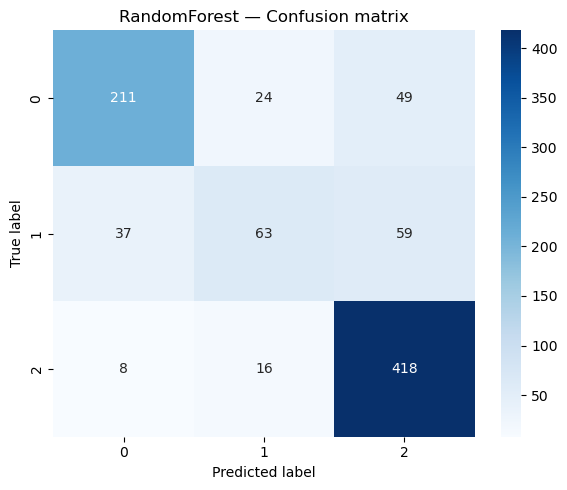

In [72]:
results.append(run_random_forest(**evaluate_with_features("Hand Selected Features", selected_features)))

In [75]:
def run_xtra_trees(X_train, y_train, X_test, y_test, feature_list, name):
    
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")

    et = ExtraTreesClassifier(
        n_estimators=800,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE
    )
    
    et.fit(X_train, y_train)
    
    print(f"\n[{name}] XtraTrees fitted")
    
    y_pred_et = et.predict(X_test)
    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred_et),
        "test_f1_macro": f1_score(y_test, y_pred_et, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred_et, average="weighted"),
    }
    
    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")
    
    class_labels = et.classes_ ## We can inverse transform with the label encoder
    et_cm = show_confusion_matrix(y_test, y_pred_et, class_labels, title="XtraTrees — Confusion matrix")
    
    return {
        "name": name,
        "features": feature_list,
        "cv_model": et,
        "test_metrics": test_metrics,
    }

[Job check] Detected CPU cores: 8. Using n_jobs=8.

[Hand Selected Features] XtraTrees fitted

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7650
  test_f1_macro: 0.6939
  test_f1_weighted: 0.7541

XtraTrees — Confusion matrix (rows = true, cols = pred)


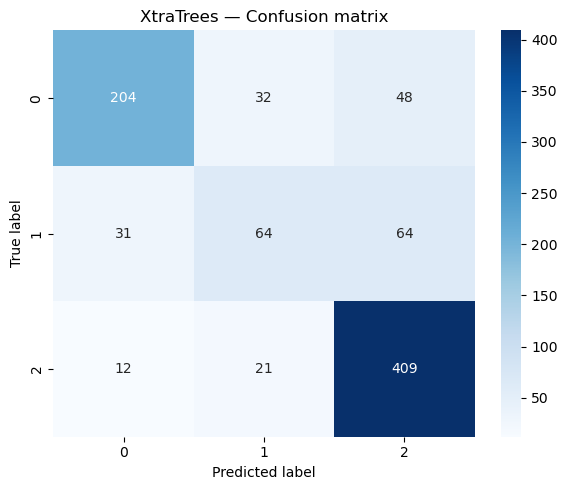

In [76]:
results.append(run_xtra_trees(**evaluate_with_features("Hand Selected Features", selected_features)))

In [86]:
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [78]:
def run_lightgbm(X_train, y_train, X_test, y_test, feature_list, name):
    
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")

    lgbm = lgb.LGBMClassifier(
        n_estimators=2000,            # now always runs all 2000 rounds
        learning_rate=0.05,
        num_leaves=31,
        objective="multiclass",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        importance_type="gain"
    )
    lgbm.fit(X_train, y_train)

    print(f"\n[{name}] LightGBM fitted")
    
    y_pred_lgbm = lgbm.predict(X_test)
    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred_lgbm),
        "test_f1_macro": f1_score(y_test, y_pred_lgbm, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred_lgbm, average="weighted"),
    }
    
    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")
    
    class_labels = lgbm.classes_ ## We can inverse transform with the label encoder
    lgbm_cm = show_confusion_matrix(y_test, y_pred_lgbm, class_labels, title="LightGBM — Confusion matrix")
    
    return {
        "name": name,
        "features": feature_list,
        "cv_model": lgbm,
        "test_metrics": test_metrics,
    }

[Job check] Detected CPU cores: 8. Using n_jobs=8.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 44
[LightGBM] [Info] Start training from score -1.135451
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.694561

[Hand Selected Features] LightGBM fitted

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7627
  test_f1_macro: 0.6929
  test_f1_weighted: 0.7531

LightGBM — Confusion matrix (rows = true, cols = pred)


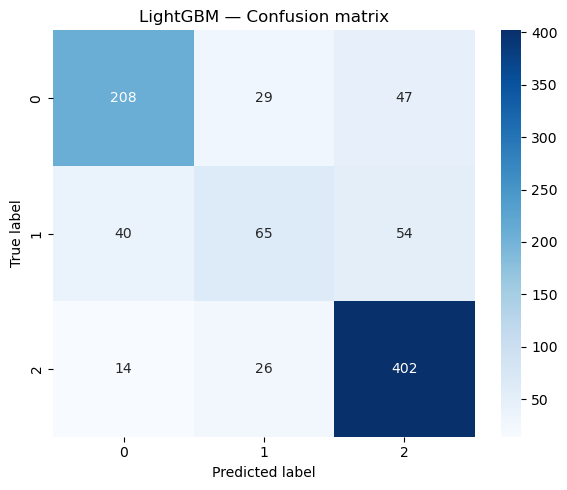

In [79]:
results.append(run_lightgbm(**evaluate_with_features("Hand Selected Features", selected_features)))

In [82]:
def run_catboost(X_train, y_train, X_test, y_test, feature_list, name):
    
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")
    
    #cat_features_idx = None  # set to list of indices if you want native categorical handling

    cbc = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        loss_function="MultiClass",
        eval_metric="TotalF1",
        random_seed=RANDOM_STATE,
        verbose=False,
        # auto_class_weights="Balanced",  # optionally enable if classes are imbalanced
    )
    
    cbc.fit(X_train, y_train)

    print(f"\n[{name}] CatBoost fitted")
    
    y_pred_cbc = cbc.predict(X_test)
    
    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred_cbc),
        "test_f1_macro": f1_score(y_test, y_pred_cbc, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred_cbc, average="weighted"),
    }
    
    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")
    
    class_labels = cbc.classes_ ## We can inverse transform with the label encoder
    cbc_cm = show_confusion_matrix(y_test, y_pred_cbc, class_labels, title="CatBoost — Confusion matrix")
    
    return {
        "name": name,
        "features": feature_list,
        "cv_model": cbc,
        "test_metrics": test_metrics,
    }

[Job check] Detected CPU cores: 8. Using n_jobs=8.

[Hand Selected Features] CatBoost fitted

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7785
  test_f1_macro: 0.7064
  test_f1_weighted: 0.7672

CatBoost — Confusion matrix (rows = true, cols = pred)


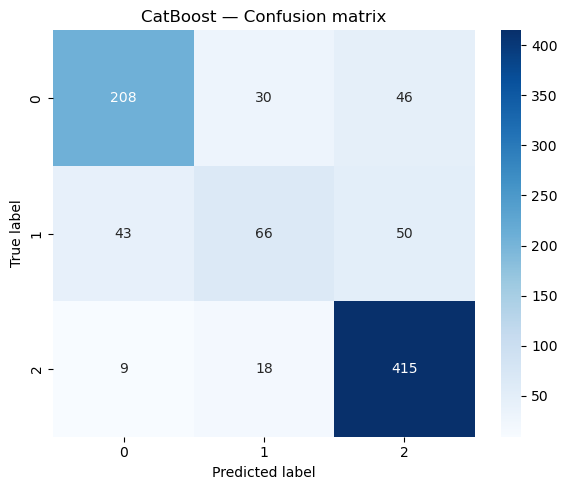

In [83]:
results.append(run_catboost(**evaluate_with_features("Hand Selected Features", selected_features)))

In [91]:
from xgboost.callback import EarlyStopping

In [97]:
from xgboost import DMatrix, train as xgb_train

In [106]:
def run_xgboost(X_train, y_train, X_test, y_test, feature_list, name):
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")

    # Hold out a small validation fold for early stopping
    X_tr_sm, X_val_sm, y_tr_sm, y_val_sm = train_test_split(
        X_train, y_train,
        test_size=0.15, stratify=y_train, random_state=RANDOM_STATE
    )
    print(f"[Split] Small validation: {X_tr_sm.shape[0]} train-sm / {X_val_sm.shape[0]} val-sm")
    
    le = LabelEncoder()
    y_tr_sm_enc = le.fit_transform(y_tr_sm)
    y_val_sm_enc = le.transform(y_val_sm)
    y_test_enc   = le.transform(y_test)
    n_classes = len(le.classes_)
    

    # DMatrix
    dtrain = DMatrix(X_tr_sm, label=y_tr_sm_enc)
    dvalid = DMatrix(X_val_sm, label=y_val_sm_enc)
    dtest  = DMatrix(X_test)

    params = {
        "objective": "multi:softprob",
        "num_class": n_classes,
        "eta": 0.05,                 # learning_rate
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "eval_metric": "mlogloss",
        "tree_method": "hist",       # use "gpu_hist" if you have a GPU
        "seed": RANDOM_STATE,
        "nthread": N_JOBS
    }

    # Train with early stopping
    num_boost_round=2000
    booster = xgb_train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "validation")],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    # Best iteration info
    best_iter = getattr(booster, "best_iteration", None) # don't need this most likely
    best_ntree_limit = getattr(booster, "best_ntree_limit", None)
    
    if best_iter is not None:
        print(f"[{name}] Early stopping: best_iteration = {best_iter + 1}")
    elif best_ntree_limit is not None:
        # Older versions expose only best_ntree_limit
        print(f"[{name}] Early stopping: best_ntree_limit = {best_ntree_limit}")
    else:
        print(f"[{name}] Early stopping not triggered; using all {num_boost_round} rounds")

    # Predict using best iteration
    if best_ntree_limit is not None:
        probs = booster.predict(dtest, ntree_limit=best_ntree_limit)
        used_iters = best_ntree_limit
    elif best_iter is not None:
        # best_iteration is 0-based; +1 trees used
        probs = booster.predict(dtest, iteration_range=(0, best_iter + 1))
        used_iters = best_iter + 1
    else:
        probs = booster.predict(dtest)
        used_iters = num_boost_round

    y_pred_idx = probs.argmax(axis=1)
    y_pred_xgb = le.inverse_transform(y_pred_idx)

    print(f"\n[{name}] XGBoost fitted with {used_iters} trees")

    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred_xgb),
        "test_f1_macro": f1_score(y_test, y_pred_xgb, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred_xgb, average="weighted"),
    }

    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")

    class_labels = le.classes_
    xgb_cm = show_confusion_matrix(
        y_test, y_pred_xgb, class_labels, title="XGBoost — Confusion matrix"
    )

    return {
        "name": name,
        "features": feature_list,
        "cv_model": booster,          # xgboost Booster
        "label_encoder": le,          # so you can inverse_transform later if needed
        "test_metrics": test_metrics,
        "best_iteration": used_iters,
    }

[Job check] Detected CPU cores: 8. Using n_jobs=8.
[Split] Small validation: 3008 train-sm / 531 val-sm
[Hand Selected Features] Early stopping: best_iteration = 91

[Hand Selected Features] XGBoost fitted with 91 trees

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7831
  test_f1_macro: 0.7140
  test_f1_weighted: 0.7720

XGBoost — Confusion matrix (rows = true, cols = pred)


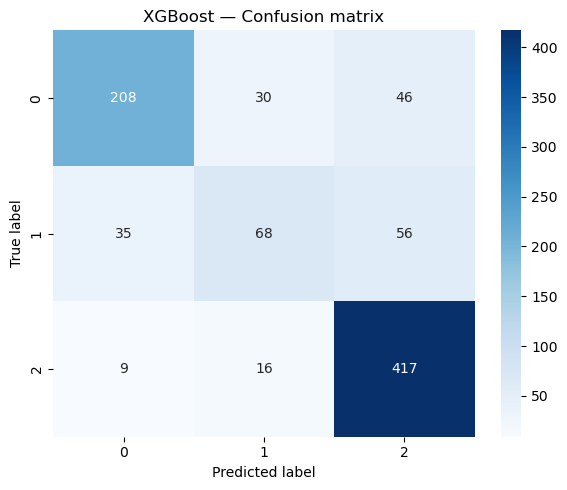

In [107]:
results.append(run_xgboost(**evaluate_with_features("Hand Selected Features", selected_features)))

#### Simple CV search (no ES in CV)

In [96]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [112]:
def run_xgb_hparam_search_simple(X_train, y_train, X_test, y_test, feature_list, name,
    n_iter=40):
    
    random_state=RANDOM_STATE
    CPU_CORES = os.cpu_count() or 1
    N_JOBS = CPU_CORES
    print(f"[Job check] Detected CPU cores: {CPU_CORES}. Using n_jobs={N_JOBS}.")

    xgb_est = XGBClassifier(
        objective="multi:softprob",
        tree_method="hist",          # "gpu_hist" if GPU
        eval_metric="mlogloss",
        random_state=random_state,
        n_jobs=N_JOBS
    )

    param_dist = {
        "learning_rate": [0.02, 0.03, 0.05, 0.07, 0.1],
        "max_depth": [4, 6, 8],
        "min_child_weight": [1, 2, 5],
        "gamma": [0.0, 0.5, 1.0, 5.0],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "reg_alpha": [0.0, 1e-3, 1e-2, 0.1],
        "reg_lambda": [0.5, 1.0, 2.0, 5.0],
        "n_estimators": [300, 600, 900, 1200, 1500],  # tune directly (no ES)
    }
    
    cv = RepeatedStratifiedKFold(
        n_splits=5,
        n_repeats=3,              # try 2–5 repeats; 3 is a good start
        random_state=random_state
    )
    
    '''- Variance reduction: multiple independent stratified splits → average the metric across more folds → 
    less sensitivity to a “lucky” or “unlucky” split.
    - More reliable model selection: hyperparameters that only work on one split are less likely to “win” 
    across many repeats.
    - Longer runtime: cost scales roughly linearly with the number of folds. If you go from 5-fold to 5×3=15 
    folds, expect ~3× more training time for the same n_iter.
    '''

    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    # Repeated had lower performance than Regular Stratified

    search = RandomizedSearchCV(
        estimator=xgb_est,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="f1_macro",
        cv=cv,
        verbose=1,
        n_jobs=CPU_CORES,
        refit=True,
        random_state=random_state
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print(f"[{name}] Best params: {search.best_params_}")
    print(f"[{name}] CV best score (macro-F1): {search.best_score_:.4f}")

    y_pred = best_model.predict(X_test)
    test_metrics = {
        "n_features": len(feature_list),
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_f1_macro": f1_score(y_test, y_pred, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    }

    print(f"\n[{name}] TEST metrics")
    for k, v in test_metrics.items():
        if k == "n_features":
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")

    class_labels = best_model.classes_
    xgb_cm = show_confusion_matrix(
        y_test, y_pred, class_labels, title="XGBoost(HS) — Confusion matrix"
    )

    return {
        "name": name,
        "features": feature_list,
        "cv_model": best_model,
        "test_metrics": test_metrics,
        "best_params": search.best_params_,
        "cv_best_f1_macro": search.best_score_,
    }


[Job check] Detected CPU cores: 8. Using n_jobs=8.
Fitting 15 folds for each of 40 candidates, totalling 600 fits
[Hand Selected Features] Best params: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.01, 'n_estimators': 900, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.8}
[Hand Selected Features] CV best score (macro-F1): 0.6914

[Hand Selected Features] TEST metrics
  n_features: 45
  test_accuracy: 0.7751
  test_f1_macro: 0.7081
  test_f1_weighted: 0.7664

XGBoost(HS) — Confusion matrix (rows = true, cols = pred)


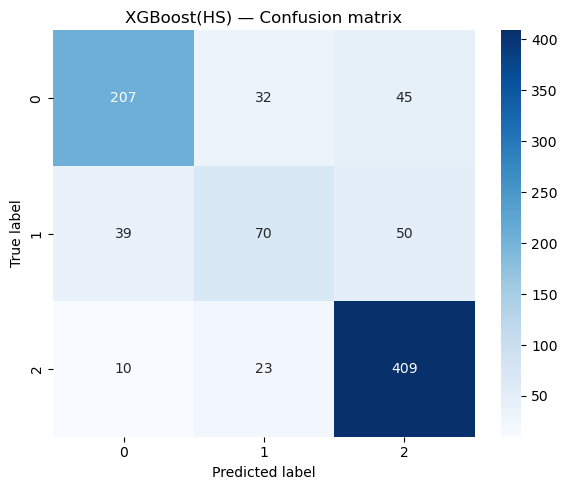

In [113]:
results.append(run_xgb_hparam_search_simple(**evaluate_with_features("Hand Selected Features", selected_features)))